# Assignment 2

- Train a linear regression model that maps features to expert scores based on the dataset
- Try different variants using, e.g., feature selection, combined features, removal of outlier and leverage data points, apply symmetry constraints, weighted linear regression
- Assess the accuracy of the models and select a champion variant

## Imports

In [23]:
import sys

sys.path.append("../../scripts")

import dagshub
import mlflow
import ML_utils as MLUtils

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

## Setup

In [25]:
# Setup dagshub and MLFlow
dagshub.init(repo_owner="SamuelFredricBerg", repo_name="4dt907", mlflow=True)
utils = MLUtils.MLUtils("Project_Model")

# Configs
config = {
    "n_estimators": 200,
    "max_depth": 7,
    "learning_rate": 0.05,
    "feature_set": "v2_processed",
    "data_split_seed": 42,
}

data_path = "../../data/AimoScore_WeakLink_big_scores_A2.csv"

df = pd.read_csv(data_path, index_col=0)

Initialized MLflow to track repo "SamuelFredricBerg/4dt907"

Repository SamuelFredricBerg/4dt907 initialized!

# Preprocessing

In [26]:
def preprocessing(df):
    df_cleaned = df.drop("EstimatedScore", axis=1)
    return df_cleaned

# Training

In [27]:
def fitreg(data):
    pass
    # return model

## Main Code

Number of columns: 40
Columns names: ['No_1_Angle_Deviation', 'No_2_Angle_Deviation', 'No_3_Angle_Deviation', 'No_4_Angle_Deviation', 'No_5_Angle_Deviation', 'No_6_Angle_Deviation', 'No_7_Angle_Deviation', 'No_8_Angle_Deviation', 'No_9_Angle_Deviation', 'No_10_Angle_Deviation', 'No_11_Angle_Deviation', 'No_12_Angle_Deviation', 'No_13_Angle_Deviation', 'No_1_NASM_Deviation', 'No_2_NASM_Deviation', 'No_3_NASM_Deviation', 'No_4_NASM_Deviation', 'No_5_NASM_Deviation', 'No_6_NASM_Deviation', 'No_7_NASM_Deviation', 'No_8_NASM_Deviation', 'No_9_NASM_Deviation', 'No_10_NASM_Deviation', 'No_11_NASM_Deviation', 'No_12_NASM_Deviation', 'No_13_NASM_Deviation', 'No_14_NASM_Deviation', 'No_15_NASM_Deviation', 'No_16_NASM_Deviation', 'No_17_NASM_Deviation', 'No_18_NASM_Deviation', 'No_19_NASM_Deviation', 'No_20_NASM_Deviation', 'No_21_NASM_Deviation', 'No_22_NASM_Deviation', 'No_23_NASM_Deviation', 'No_24_NASM_Deviation', 'No_25_NASM_Deviation', 'No_1_Time_Deviation', 'No_2_Time_Deviation']


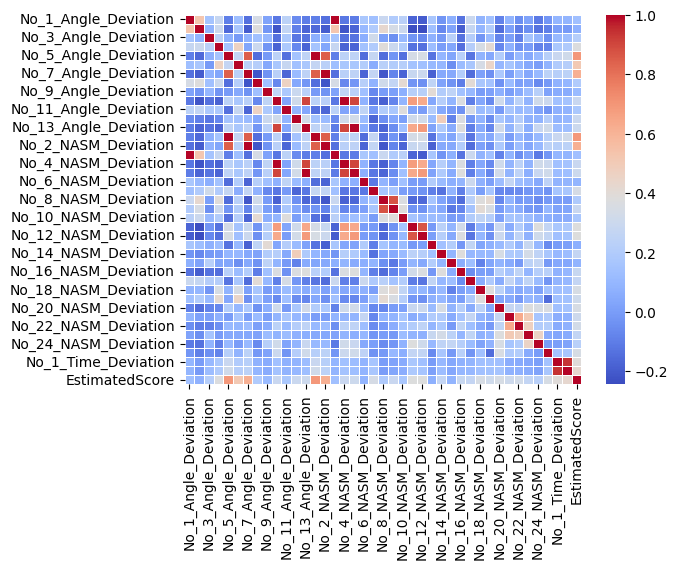

In [ ]:
df_cleaned = preprocessing(df)

df_names = df_cleaned.columns.tolist()
print(f"Number of columns: {len(df_names)}")
print(f"Columns names: {df_names}")

df.describe()

sns.heatmap(df.corr(), annot=False, cmap="coolwarm", fmt=".1f", linewidths=0.5)
plt.show()


# TODO: Uncomment below when reasonable results are aquired
# with mlflow.start_run(run_name="A2-Training") as run:
#     mlflow.log_params(config)

#     model = fitreg(df_cleaned)

#     # TRAINING CODE GOES HERE
#     # model = train_model()

#     # Logging results
#     # Create a dictionary for all results (EXAMPLE BELOW)
#     results = {
#         "accuracy": 0.942,
#         "f1_score": 0.915,
#         "precision": 0.920,
#         "recall": 0.910,
#     }
#     mlflow.log_metrics(results)

#     # Logging visuals
#     # Example how to below
#     # plt.savefig("feature_importance.png")
#     # mlflow.log_artifact("feature_importance.png")

#     if utils.auto_check_challenger(run.info.run_id, metric_name="accuracy"):
#         mlflow.sklearn.log_model(model, "model", registered_model_name="Project_Model")

#         latest_v = utils.client.get_latest_versions("Project_Model")[0].version
#         utils.client.set_registered_model_alias("Project_Model", "dev", latest_v)
#         print("New model beat current @dev uploading to DagsHub")
#     else:
#         print("Did not beat current @dev, model not uploaded to Dagshub")